In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 25.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU is active: {device_name}")
else:
    print("No GPU detected")


GPU is active: /device:GPU:0


In [ ]:
# Import the Nilearn library
from nilearn import datasets
import nilearn.datasets
from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Import the necessary libraries

from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
from sklearn.impute import SimpleImputer



**Pre-Processing**

In [ ]:
# Import libraries
import numpy as np
import nibabel as nib
import cv2
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout,
                                     UpSampling2D, concatenate, GlobalAveragePooling2D, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from nilearn.datasets import fetch_oasis_vbm
import tensorflow as tf

In [ ]:
from nilearn.datasets import fetch_oasis_vbm
from sklearn.metrics import (classification_report, precision_score, recall_score, f1_score, balanced_accuracy_score, brier_score_loss, log_loss, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.layers import Flatten

In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Load the dataset and preprocess metadata (ext_vars)
dataset=nilearn.datasets.fetch_oasis_vbm(n_subjects=None, dartel_version=True, data_dir=None, url=None, resume=True, verbose=1)
metadata = dataset.ext_vars

metadata = metadata[metadata['cdr'].notna()].copy()
metadata['cdr'] = metadata['cdr'].astype(float)
metadata['demented'] = (metadata['cdr'] > 0).astype(int)

metadata = metadata.iloc[:len(dataset.gray_matter_maps)].reset_index(drop=True)


[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

In [ ]:
# Preprocess and standardize each MRI slice
def preprocess(df):
    X, y = [], []
    for idx in df.index:
        label = df.loc[idx, 'demented']
        img_path = dataset.gray_matter_maps[idx]

        img = nib.load(img_path)
        data = img.get_fdata()
        slice_ = data[:, :, data.shape[2] // 2]    # take middle axial slice

        # Z-score normalization
        mean = np.mean(slice_)
        std = np.std(slice_)
        if std == 0: std = 1e-8                    # avoid division by zero
        slice_zscore = (slice_ - mean) / std

        # Only accept slices with expected shape
        if slice_zscore.shape == (91, 109):
            X.append(slice_zscore[..., np.newaxis])    # add channel dim
            y.append(label)

    return np.array(X), np.array(y)

# Resize standardized slices
def resize_images(X, new_shape=(256, 256)):
    resized_X = []
    for img in X:
        img_resized = cv2.resize(img.squeeze(), new_shape, interpolation=cv2.INTER_AREA)
        resized_X.append(img_resized[..., np.newaxis])  # restore channel dim
    return np.array(resized_X)

# Apply preprocessing
X, y = preprocess(metadata)
X_resized = resize_images(X)


In [ ]:
# Split the data
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [ ]:
# U-Net architecture was retrived from this GitHub repository https://github.com/fwrhine/ImprovedUNet.git

**U-Net+Adaboost**

In [ ]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

def improved_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting path
    c1 = Conv2D(16, 3, padding='same')(inputs)
    c1 = LeakyReLU(negative_slope=0.01)(c1)
    c1 = Conv2D(16, 3, padding='same')(c1)
    c1 = LeakyReLU(negative_slope=0.01)(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, padding='same')(p1)
    c2 = LeakyReLU(negative_slope=0.01)(c2)
    c2 = Conv2D(32, 3, padding='same')(c2)
    c2 = LeakyReLU(negative_slope=0.01)(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, padding='same')(p2)
    c3 = LeakyReLU(negative_slope=0.01)(c3)
    c3 = Conv2D(64, 3, padding='same')(c3)
    c3 = LeakyReLU(negative_slope=0.01)(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(128, 3, padding='same')(p3)
    c4 = LeakyReLU(negative_slope=0.01)(c4)
    c4 = Conv2D(128, 3, padding='same')(c4)
    c4 = LeakyReLU(negative_slope=0.01)(c4)

    gap = GlobalAveragePooling2D()(c4)
    output = Dense(1, activation='sigmoid')(gap)

    model = Model(inputs, output)
    feature_extractor = Model(inputs=inputs, outputs=c4)  # output features

    return model, feature_extractor

# Instantiate the model and feature_extractor
input_shape = (256, 256, 1)
model, feature_extractor = improved_unet(input_shape)

# Show model architecture summary
model.summary()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_112 (LeakyReLU)     │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_113 (LeakyReLU)     │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_114 (LeakyReLU)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_115 (LeakyReLU)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_116 (LeakyReLU)     │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_117 (LeakyReLU)     │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_118 (LeakyReLU)     │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_119 (LeakyReLU)     │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,361 (1.12 MB)

 Trainable params: 293,361 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compute class weights to counteract the class imbalance in the dataset. This step is necessary to improve the model training that follows

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Build and compile the model
model, feature_extractor = improved_unet((256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[early_stop], class_weight=class_weights_dict, verbose=1)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.6036 - loss: 0.6969 - val_accuracy: 0.5833 - val_loss: 0.6927
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.5281 - loss: 0.6871 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.3964 - loss: 0.6874 - val_accuracy: 0.4167 - val_loss: 0.6936


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.style.use('default')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='gold')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='gold')
    plt.title('Binary Cross-Entropy Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


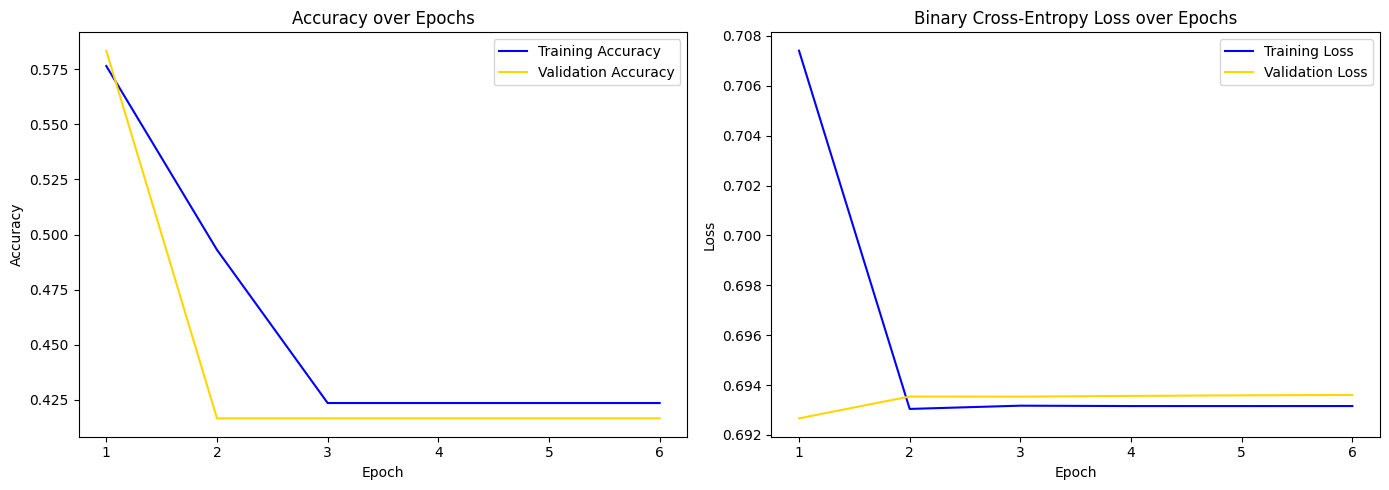

In [ ]:
plot_training_history(history)

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow.python.data.ops.structured_function')


In [ ]:
# Define the input data for feature extraction
X_data = np.concatenate([X_train, X_val], axis=0)

# Extract features from trained model (from the c4 layer, before GAP and sigmoid)
features = feature_extractor.predict(X_data)
print("Extracted feature shape:", features.shape)


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Extracted feature shape: (180, 32, 32, 128)


In [ ]:
# Adaboost hyperparameters were retrived from the following paper: Javeed, A., Dallora, A. L., Berglund, J. S., & Anderberg, P. (2022). An intelligent learning system for unbiased prediction
# of dementia based on autoencoder and adaboost ensemble learning. Life, 12(7), 1097.

In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
import optuna

# features shape = (n_samples, 32, 32, 128)
# Flatten features
n_samples = features.shape[0]
features_flat = features.reshape(n_samples, -1)

# Use labels for training
y_train_val = np.concatenate([y_train, y_val], axis=0)

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_categorical('n_estimators', [10, 50, 100, 200, 300, 400])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1])
    Fe = trial.suggest_categorical('Fe', [5, 10, 15, 20, 25])     # features extracted

    # Dimensionality reduction using PCA
    pca = PCA(n_components=Fe)
    X_reduced = pca.fit_transform(features_flat)

    # AdaBoost classifier
    clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate with cross-validation accuracy
    scores = cross_val_score(clf, X_reduced, y_train_val, cv=cv, scoring='accuracy')
    mean_score = scores.mean()

    return mean_score


In [ ]:
# Create Optuna study and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)

Best hyperparameters: {'n_estimators': 300, 'learning_rate': 0.1, 'Fe': 10}
Best cross-validation accuracy: 0.5888888888888889


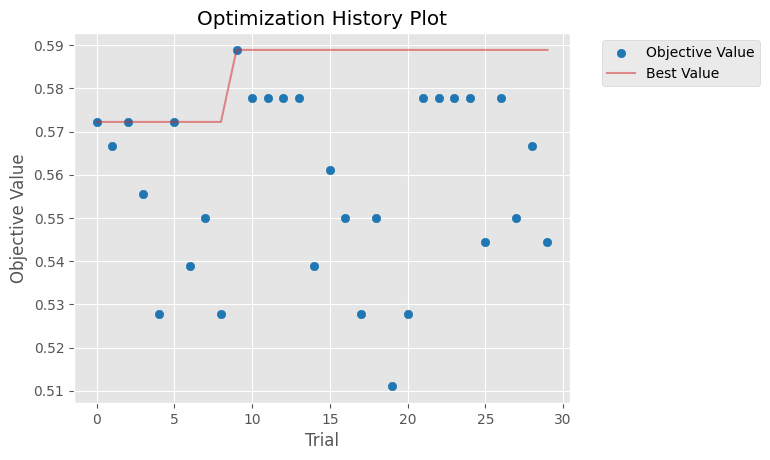

In [ ]:
import warnings
import optuna.visualization.matplotlib as vis_matplotlib

# Suppress warning and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study)

# Save the plot
fig = ax.figure
fig.savefig("optuna_optimization_history_unetadaboost.png", dpi=300, bbox_inches='tight')

In [ ]:
adaboost_params = study.best_params
print(adaboost_params)

{'n_estimators': 300, 'learning_rate': 0.1, 'Fe': 10}


In [ ]:
final_params_adaboost = dict(n_estimators = adaboost_params['n_estimators'], learning_rate = adaboost_params['learning_rate'], Fe = adaboost_params['Fe'])

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

# Already extracted features for trainval
X_trainval_flat = features.reshape(features.shape[0], -1)

# Extract and flatten test features
features_test = feature_extractor.predict(X_test)
X_test_flat = features_test.reshape(features_test.shape[0], -1)

# PCA using Fe from best Optuna parameters
pca = PCA(n_components=final_params_adaboost['Fe'])
X_trainval_reduced = pca.fit_transform(X_trainval_flat)
X_test_reduced = pca.transform(X_test_flat)



2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 790ms/step


In [ ]:
# Retrain AdaBoost with the final best hyperparameters on the combined trainval set
clf_adaboost = AdaBoostClassifier(n_estimators=final_params_adaboost['n_estimators'], learning_rate=final_params_adaboost['learning_rate'], random_state=42)
clf_adaboost.fit(X_trainval_reduced, y_trainval)

AdaBoostClassifier(learning_rate=0.1, n_estimators=300, random_state=42)

In [ ]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, log_loss, brier_score_loss, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc)

# Define the evaluate_model function to compute the metrics, create the confusion matrix, and the ROC curve

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute the metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)  # add zero_division=0 to handle undefined metrics
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    print("\n Binary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


FINAL ADABOOST MODEL EVALUATION ON TEST SET

 Binary Classification Evaluation
Accuracy:             0.5652
Balanced Accuracy:    0.5058
Precision:            0.5000
Recall (Sensitivity): 0.0500
F1 Score:             0.0909
Log Loss:             0.6908
Brier Score:          0.2479
AUC-ROC:              0.6019

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.57      0.96      0.71        26
    Demented       0.50      0.05      0.09        20

    accuracy                           0.57        46
   macro avg       0.53      0.51      0.40        46
weighted avg       0.54      0.57      0.44        46



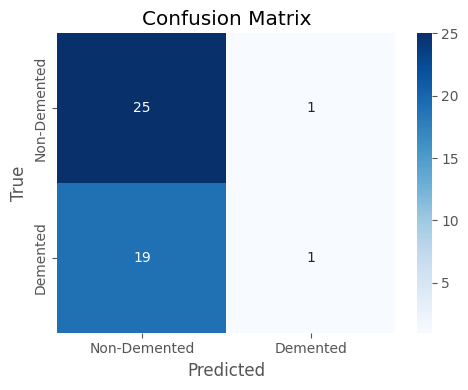

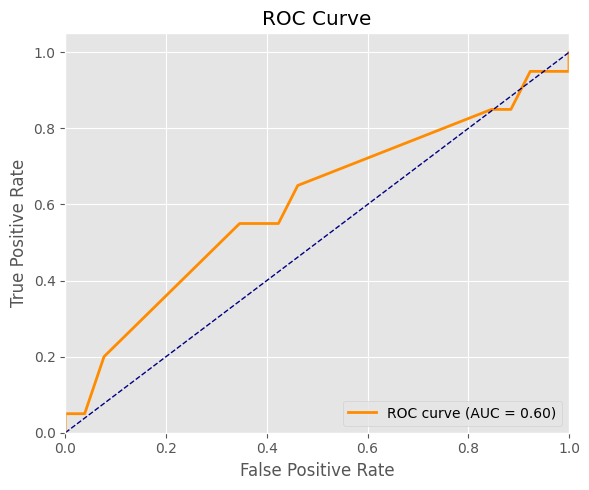

In [ ]:
# Predict on test set
y_test_pred = clf_adaboost.predict(X_test_reduced)
y_test_proba = clf_adaboost.predict_proba(X_test_reduced)[:, 1]  # Probability for class 'Demented'

# Evaluate the model
print("FINAL ADABOOST MODEL EVALUATION ON TEST SET")

test_metrics = evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])

# Plot the confusion matrix and save it
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Demented', 'Demented'],
            yticklabels=['Non-Demented', 'Demented'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (AdaBoost)")
plt.tight_layout()
plt.savefig("confusion_matrix_default_threshold.png", dpi=300)
plt.close()


EVALUATION WITH OPTIMAL THRESHOLD: 0.2236

 Binary Classification Evaluation
Accuracy:             0.4348
Balanced Accuracy:    0.5000
Precision:            0.4348
Recall (Sensitivity): 1.0000
F1 Score:             0.6061
Log Loss:             0.6908
Brier Score:          0.2479
AUC-ROC:              0.6019

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.00      0.00      0.00        26
    Demented       0.43      1.00      0.61        20

    accuracy                           0.43        46
   macro avg       0.22      0.50      0.30        46
weighted avg       0.19      0.43      0.26        46



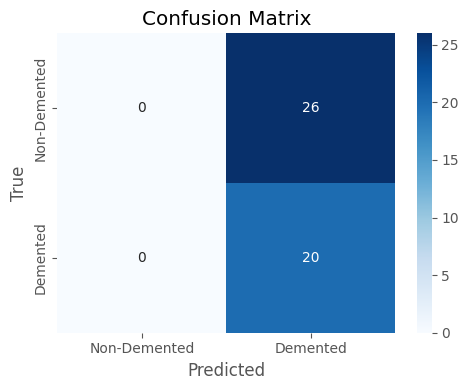

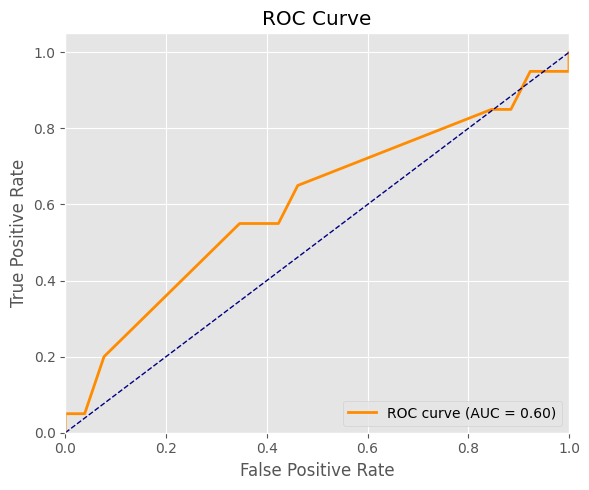

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute precision, recall, and thresholds
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"EVALUATION WITH OPTIMAL THRESHOLD: {optimal_threshold:.4f}")

# Apply optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate the model using adjusted predictions
evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred_optimal,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])

# Plot the confusion matrix for optimal threshold and save it
cm = confusion_matrix(y_test, y_test_pred_optimal)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Demented', 'Demented'],
            yticklabels=['Non-Demented', 'Demented'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
plt.tight_layout()
plt.savefig("confusion_matrix_optimal_threshold.png", dpi=300)
plt.close()


**Model Comparison**

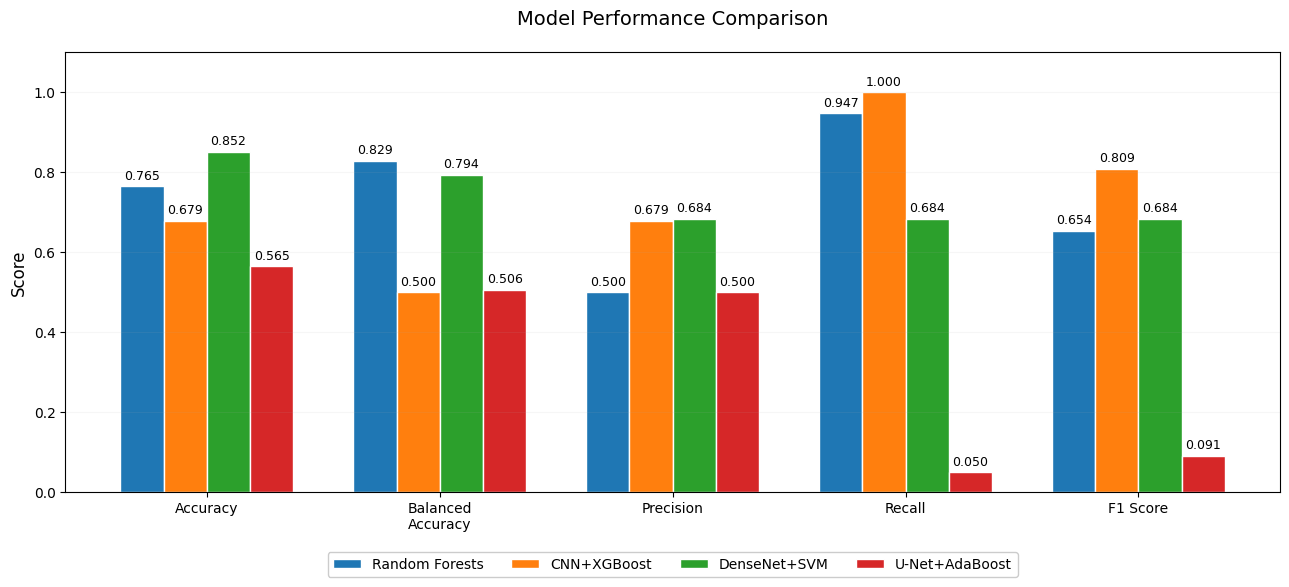

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Model names and metrics
models = ['Random Forests', 'CNN+XGBoost', 'DenseNet+SVM', 'U-Net+AdaBoost']
metrics_main = {
    'Accuracy': [0.7654, 0.6790, 0.8519, 0.5652],
    'Balanced\nAccuracy': [0.8285, 0.5000, 0.7937, 0.5058],
    'Precision': [0.5000, 0.6790, 0.6842, 0.5000],
    'Recall': [0.9474, 1.0000, 0.6842, 0.0500],
    'F1 Score': [0.6545, 0.8088, 0.6842, 0.0909]}

# Style settings
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.1
plt.rcParams['font.size'] = 10

# Colors for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create DataFrame
df_main = pd.DataFrame(metrics_main, index=models)

# Plot settings
fig, ax = plt.subplots(figsize=(13, 6))
x = np.arange(len(metrics_main))
width = 0.18
spacing = 0.25

# Bar plot for each model
for i, model in enumerate(models):
    values = [df_main.loc[model, metric] for metric in metrics_main]
    values = [np.nan if v is None else v for v in values]
    x_pos = x * (width * len(models) + spacing) + i * width
    bars = ax.bar(x_pos, values, width, label=model, color=colors[i], edgecolor='white')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Axis labels and formatting
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, pad=20)
ax.set_xticks(x * (width * len(models) + spacing) + (width * len(models)) / 2 - width / 2)
ax.set_xticklabels(list(metrics_main.keys()), fontsize=10)
ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, framealpha=1)
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig("model_metrics.png", dpi=300)
plt.close()


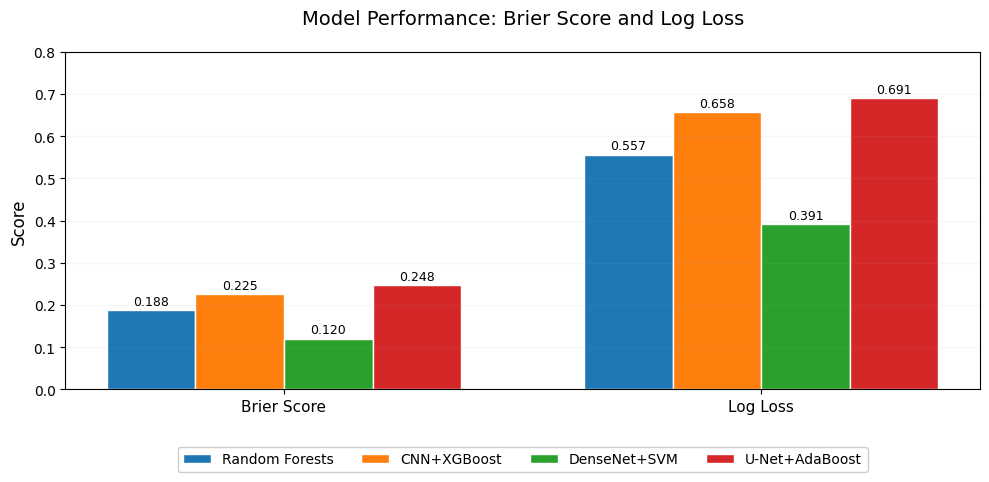

In [2]:
# Create a plot for Brier Score and Log Loss
metrics_secondary = {'Brier Score': [0.1875, 0.2252, 0.1203, 0.2479], 'Log Loss': [0.5566, 0.6580, 0.3910, 0.6908]}
df_secondary = pd.DataFrame(metrics_secondary, index=models)

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(metrics_secondary))
width = 0.18
spacing = 0.25

for i, model in enumerate(models):
    values = [df_secondary.loc[model, metric] for metric in metrics_secondary]
    values = [np.nan if v is None else v for v in values]
    x_pos = x * (width * len(models) + spacing) + i * width
    bars = ax.bar(x_pos, values, width, label=model, color=colors[i], edgecolor='white')
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance: Brier Score and Log Loss', fontsize=14, pad=20)
ax.set_xticks(x * (width * len(models) + spacing) + (width * len(models)) / 2 - width / 2)
ax.set_xticklabels(list(metrics_secondary.keys()), fontsize=11)
ax.set_ylim(0, 0.8)
ax.set_yticks(np.arange(0, 0.9, 0.1))
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, framealpha=1)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig("model_secondary_metrics.png", dpi=300)
plt.close()
